# Document AI Specialized Parser
This notebook shows you how use Document AI's specialized parsers ex. Invoice, Receipt, W2, W9, etc.

In [1]:
# Install necessary Python libraries and restart your kernel after.
!python -m pip install -r ../requirements.txt

In [2]:
from google.cloud import documentai_v1beta3 as documentai
from PIL import Image, ImageDraw

import os
import pandas as pd

## Set your processor variables 

In [3]:
PROJECT_ID = "rand-automl-project"
LOCATION = "us"  # Format is 'us' or 'eu'
PROCESSOR_ID = "c02dd037212c7ce0"  # Create processor in Cloud Console
PDF_PATH = "../resources/lending/w2/2020/0411-w2-hz-hw.pdf" # Update to path of target document

The following code calls the synchronous API and parses the form fields and values.

In [4]:
def process_document_sample():
    # Instantiates a client
    client_options = {"api_endpoint": "{}-documentai.googleapis.com".format(LOCATION)}
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

    with open(PDF_PATH, "rb") as image:
        image_content = image.read()

    # Read the file into memory
    document = {"content": image_content, "mime_type": "application/pdf"}

    # Configure the process request
    request = {"name": name, "document": document}

    # Recognizes text entities in the PDF document
    result = client.process_document(request=request)
    document = result.document
    entities = document.entities
    print("Document processing complete.\n\n")

    # For a full list of Document object attributes, please reference this page: https://googleapis.dev/python/documentai/latest/_modules/google/cloud/documentai_v1beta3/types/document.html#Document  
    types = []
    values = []
    confidence = []
    
    # Grab each key/value pair and their corresponding confidence scores.
    for entity in entities:
        types.append(entity.type_)
        values.append(entity.mention_text)
        confidence.append(round(entity.confidence,4))
        
    # Create a Pandas Dataframe to print the values in tabular format. 
    df = pd.DataFrame({'Type': types, 'Value': values, 'Confidence': confidence})
    display(df)
    
    if result.human_review_operation:
        print ("Triggered HITL long running operation: {}".format(result.human_review_operation))

    return document


def get_text(doc_element: dict, document: dict):
    """
    Document AI identifies form fields by their offsets
    in document text. This function converts offsets
    to text snippets.
    """
    response = ""
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    for segment in doc_element.text_anchor.text_segments:
        start_index = (
            int(segment.start_index)
            if segment in doc_element.text_anchor.text_segments
            else 0
        )
        end_index = int(segment.end_index)
        response += document.text[start_index:end_index]
    return response

In [5]:
doc = process_document_sample()

Document processing complete.




,Type,Value,Confidence
0,SSN,496022149,0.9000
1,EIN,100306219,0.9000
2,WagesTipsOtherCompensation,128279.00,0.5673
3,FederalIncomeTaxWithheld,30786.96,0.4658
4,EmployerNameAndAddress,Cross culture ventures 8401 Quaker Avenue Lubb...,0.0790
5,SocialSecurityWages,132900.00,0.7475
6,MedicareWagesAndTips,132900.00,0.7439
7,SocialSecurityTaxWithheld,8239.80,0.8218
8,MedicareTaxWithheld,1927.05,0.9331
9,ControlNumber,20-898,0.8915


## Draw the bounding boxes¶
We will now use the spatial data returned by the processor to mark our values on the invoice pdf file that we first converted into a jpg.

In [6]:
JPG_PATH = "../resources/lending/w2/2020/0411-w2-hz-hw.jpg" # Update to path of a jpg of your sample document.

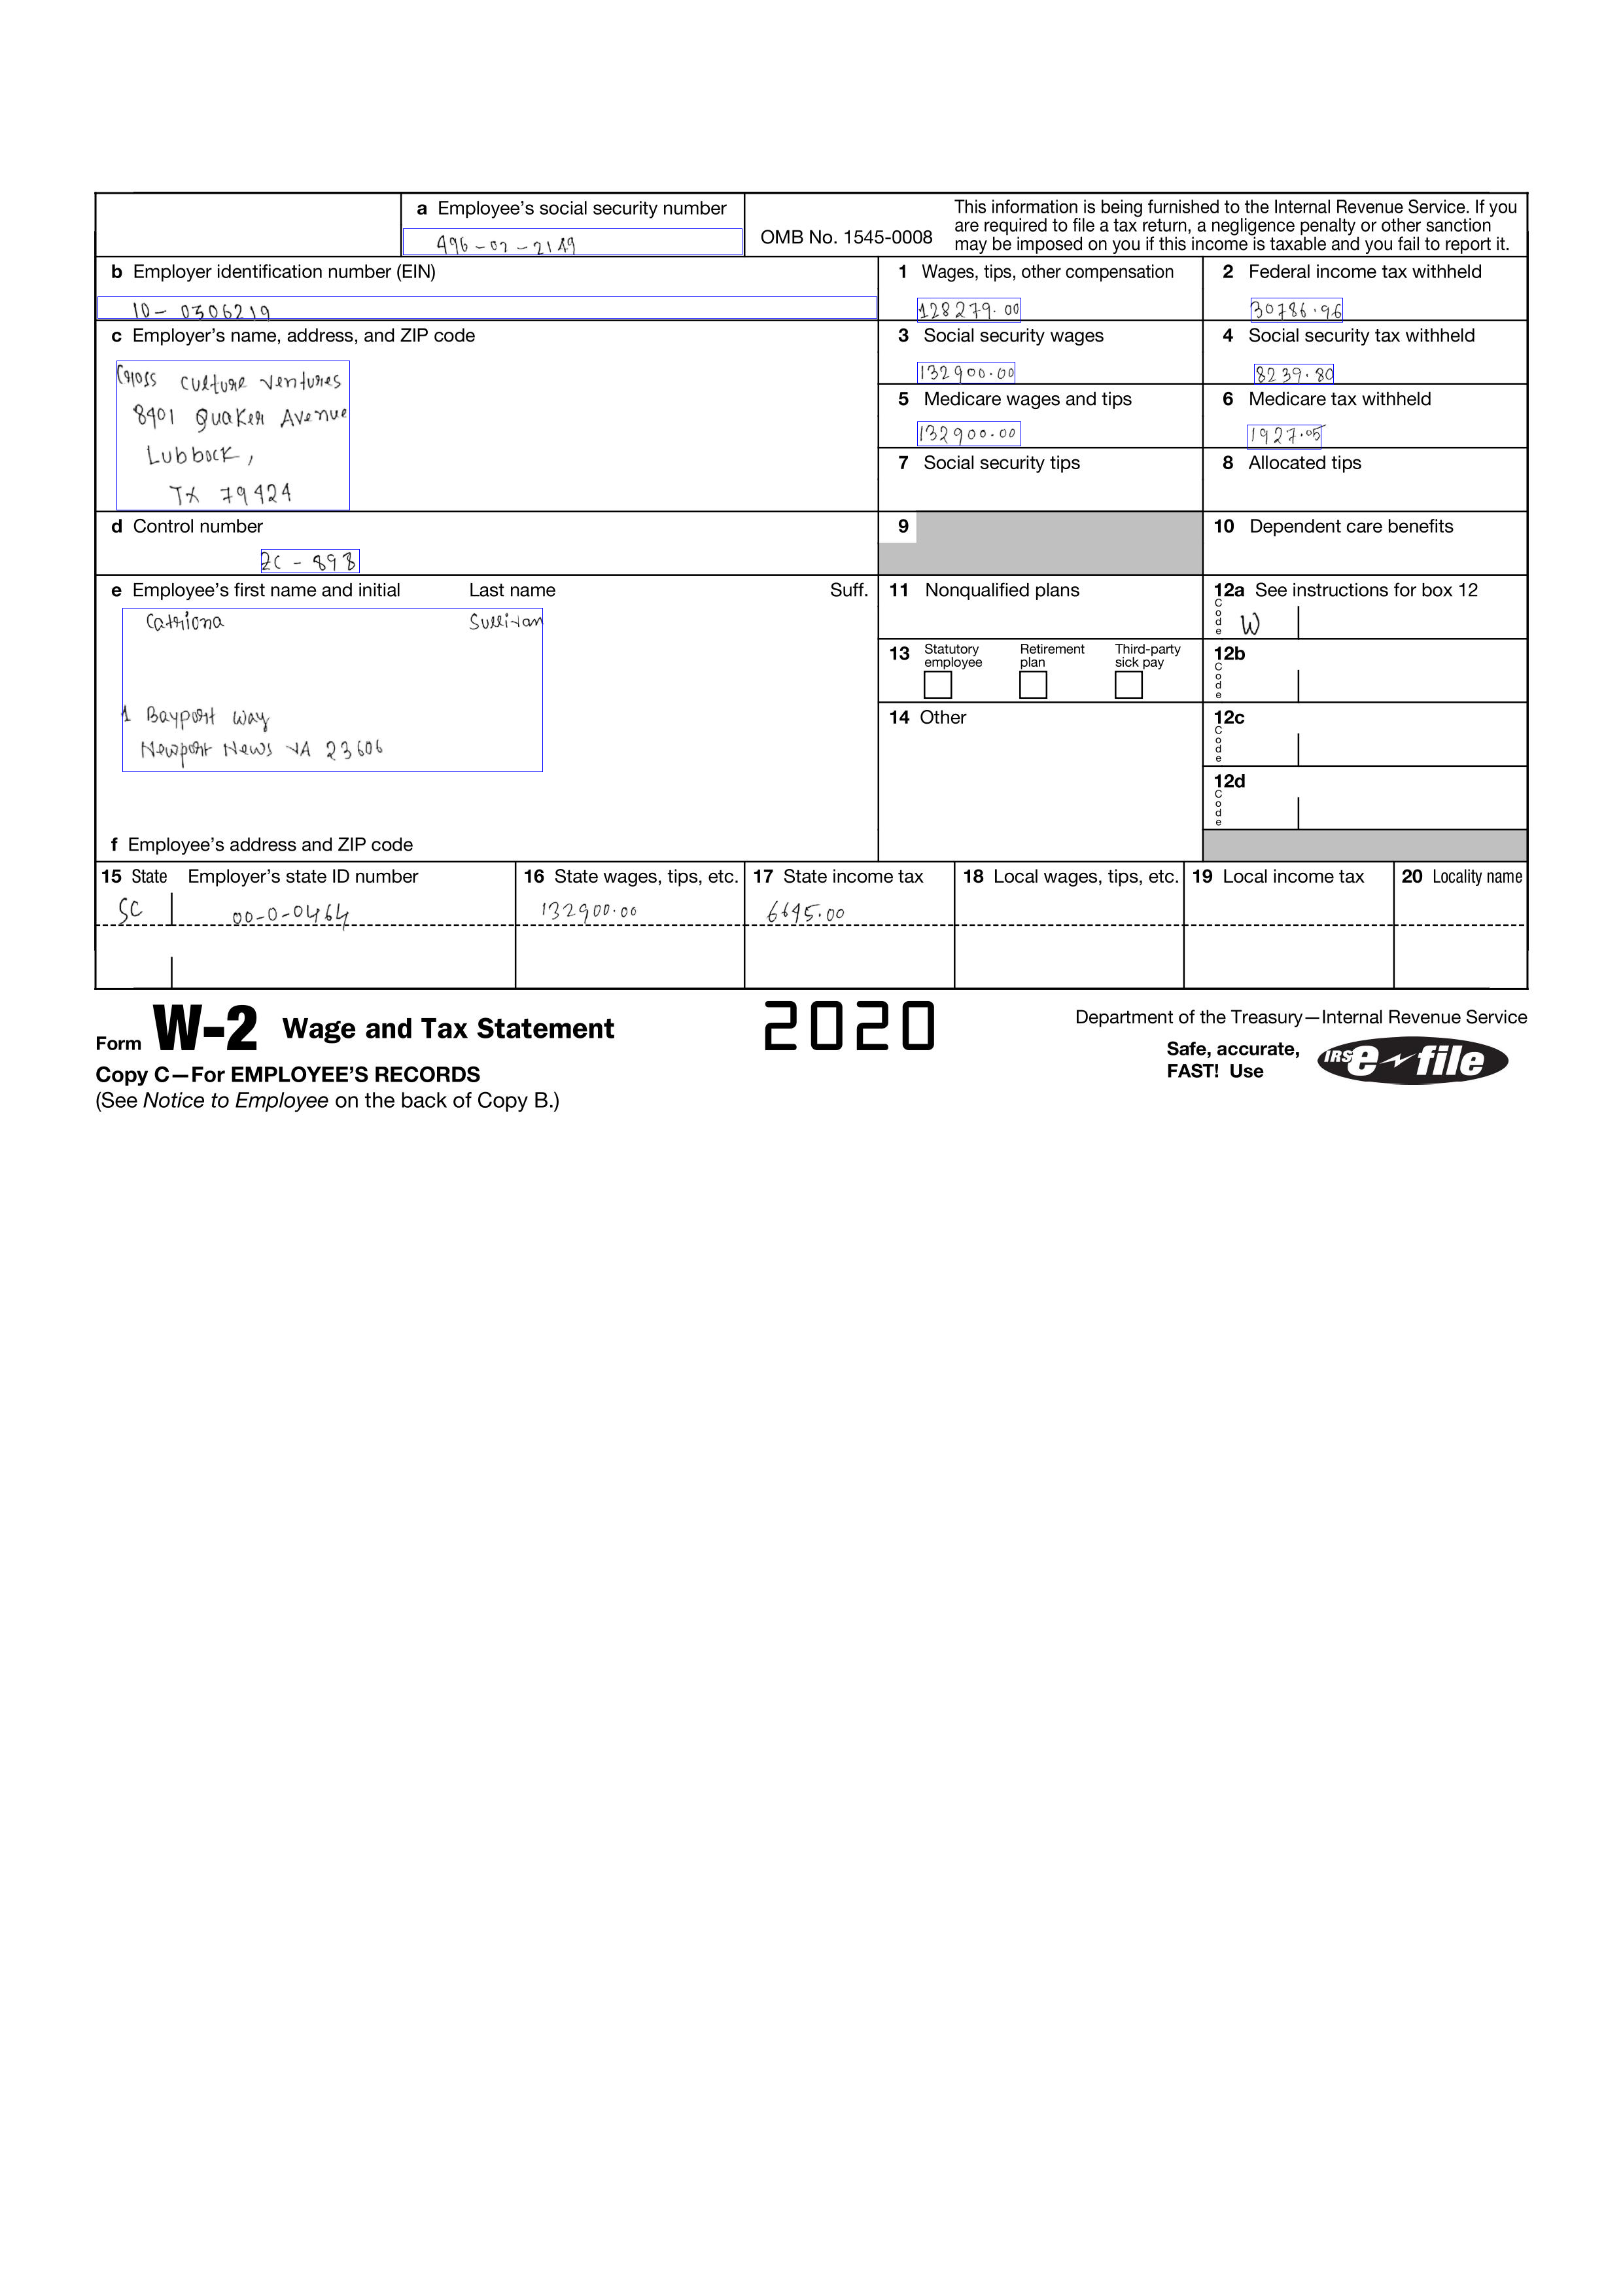

In [7]:
document_image = Image.open(JPG_PATH)
draw = ImageDraw.Draw(document_image)
for entity in doc.entities:
    # Draw the bounding box around the entities
    vertices = []
    for vertex in entity.page_anchor.page_refs[0].bounding_poly.normalized_vertices:
        vertices.append({'x': vertex.x * document_image.size[0], 'y': vertex.y * document_image.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='blue')
document_image